# GD02 Data Augmentation  
## Objective  
1. CutMix와 MixUp 기법을 ResNet50 분류기에 성공적으로 적용하였는가?  
- CutMix와 MixUp을 적용한 데이터셋으로 훈련한 각각의 ResNet 모델이 수렴하였다.  
2. 다양한 실험을 통해 태스크에 최적인 Augmentation 기법을 찾아내었는가?  
- 각 Augmentation 기법을 적용하고, 그에 따른 성능 비교 분석 및 문제점을 서술하였음  
3. 여러가지 Augmentation 기법을 적용한 결과를 체계적으로 비교분석하였는가?  
- 기본 Augmentation, CutMix, MixUp이 적용된 결과를 시각화와 함께 체계적으로 분석하였다.  

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras

import pandas as pd
import os

import tensorflow_datasets as tfds

In [2]:
tf.keras.backend.clear_session()

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [22]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [4]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

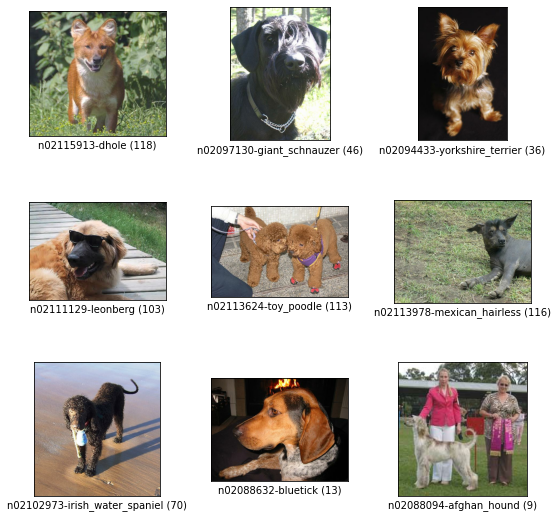

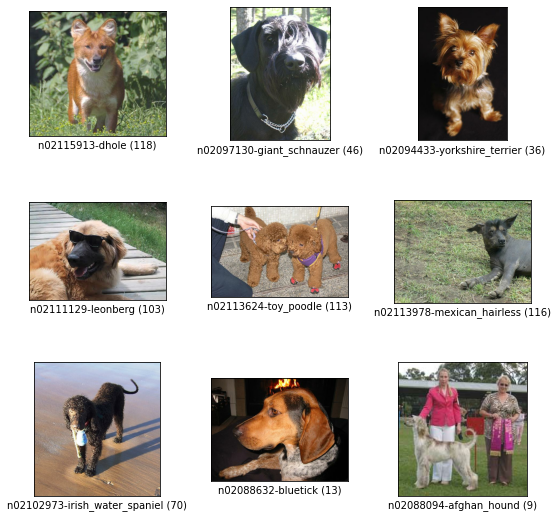

In [5]:
tfds.show_examples(ds_train, ds_info)

전처리 함수를 구현합니다

In [6]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

데이터셋 증강함수를 구현합니다  
랜덤플립상하, 밝기조정 외에 랜덤플립좌우, 색조, 채도 변경, 대비를 함게 진행합니다  

In [7]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower = 0.0, upper = 0.3)
    image = tf.image.random_hue(image, max_delta=0.1) #max_delta [0, 0.5], value will randomly picked in the interval 
    image = tf.image.random_saturation(img,lower=0,upper=3)
    image = tf.clip_by_value(image, 0, 1)
    
    return image, label

# Basic Augmentation

### Basic + Cutmix

In [8]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

In [9]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

In [10]:
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

In [11]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels


### Basic + Mixup

In [12]:
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label


In [13]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [14]:
def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

In [15]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
        
    ds = ds.batch(batch_size)
    
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
            ds = ds.map(
            mixup,
            num_parallel_calls=2
        )                
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
        
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

실험하기

In [16]:
EPOCH = 20
LEARNING_RATE = 0.01
BATCH_SIZE = 16

num_classes = ds_info.features["label"].num_classes

In [17]:
ds_test = apply_normalize_on_dataset(ds_test, is_test=True, batch_size = BATCH_SIZE)

### Without Augmentation

In [18]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, False, BATCH_SIZE)

In [23]:
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [24]:
resnet50.compile(
    loss='categorical_crossentropy',
#    optimizer= tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Adam 사용시 accuracy가 0.0077부터 10 에폭 즈음 0.02xx가 되는 성능을 보여준다  
하지말자

In [ ]:
history_resnet50 = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=2,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 - 156s - loss: 2.1896 - accuracy: 0.4499 - val_loss: 3.2867 - val_accuracy: 0.2170
Epoch 2/20
750/750 - 149s - loss: 0.7675 - accuracy: 0.7897 - val_loss: 1.1888 - val_accuracy: 0.6538
Epoch 3/20
750/750 - 149s - loss: 0.2482 - accuracy: 0.9448 - val_loss: 1.0259 - val_accuracy: 0.7064
Epoch 4/20


In [ ]:
resnet50.save("resnet50")

In [ ]:
hist_res50_df = pd.DataFrame(history_res50.history) 
hist_res50_csv_file = 'history_resnet50.csv'
with open(hist_res50_csv_file, mode='w') as f:
    hist_res50_df.to_csv(f)

In [ ]:
del resnet50
del ds_train_no_aug

### With Cutmix

In [ ]:
ds_train_cutmix = apply_normalize_on_dataset(ds_train, False, BATCH_SIZE, with_cutmix = True)

In [ ]:
resnet50_cutmix = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
resnet50_cutmix.compile(
    loss='categorical_crossentropy',
#    optimizer= tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [ ]:
history_resnet50_cutmix = resnet50.fit(
    ds_train_cutmix, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=2,
    use_multiprocessing=True,
)

In [ ]:
resnet50_cutmix.save("resnet50_cutmix")

In [ ]:
hist_res50_cutmix_df = pd.DataFrame(history_res50.history) 
hist_res50_cutmix_csv_file = 'history_resnet50_cutmix.csv'
with open(hist_res50_cutmix_csv_file, mode='w') as f:
    hist_res50_cutmix_df.to_csv(f)

In [ ]:
del resnet50_cutmix
del ds_train_cutmix

### With Mixup

In [ ]:
ds_train_mixup = apply_normalize_on_dataset(ds_train, False, BATCH_SIZE, with_mixup = True)

In [ ]:
resnet50_mixup = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
resnet50_mixup.compile(
    loss='categorical_crossentropy',
#    optimizer= tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [ ]:
history_resnet50_mixup = resnet50.fit(
    ds_train_mixup, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=2,
    use_multiprocessing=True,
)

In [ ]:
resnet50_mixup.save("resnet50_mixup")

In [ ]:
hist_res50_mixup_df = pd.DataFrame(history_res50.history) 
hist_res50_mixup_csv_file = 'history_resnet50_mixup.csv'
with open(hist_res50_mixup_csv_file, mode='w') as f:
    hist_res50_mixup_df.to_csv(f)

In [ ]:
del resnet50_mixup
del ds_train_mixup

### With Augmentation

In [ ]:
ds_train_aug = apply_normalize_on_dataset(ds_train, False, BATCH_SIZE, with_aug = True)

In [ ]:
resnet50_aug = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
resnet50_aug.compile(
    loss='categorical_crossentropy',
#    optimizer= tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [ ]:
history_resnet50_aug = resnet50.fit(
    ds_train_aug, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=2,
    use_multiprocessing=True,
)

In [ ]:
resnet50_aug.save("resnet50_aug")

In [ ]:
hist_res50_aug_df = pd.DataFrame(history_res50.history) 
hist_res50_aug_csv_file = 'history_resnet50_aug.csv'
with open(hist_res50_aug_csv_file, mode='w') as f:
    hist_res50_aug_df.to_csv(f)